In [43]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting. We set up
a rectangular analysis grid and grabbed observations within a certain
radius of inlfuence of an analysis point to then create the analysis
contoured map of 500mb heights.

"""
__author__    = "Ethan Weisberger"
__contact__   = "ethan.weisberger@und.edu"

In [44]:
### Import Required Modules (shouldn't need to change) ###

import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefile
import pandas as pd                #import pandas

In [45]:
### Read in observations ###
df=pd.read_csv("RAOBs_201903131200.txt", sep=',', names=['station', 'lat', 'lon', 'height', 'winddir', 'windsp'])

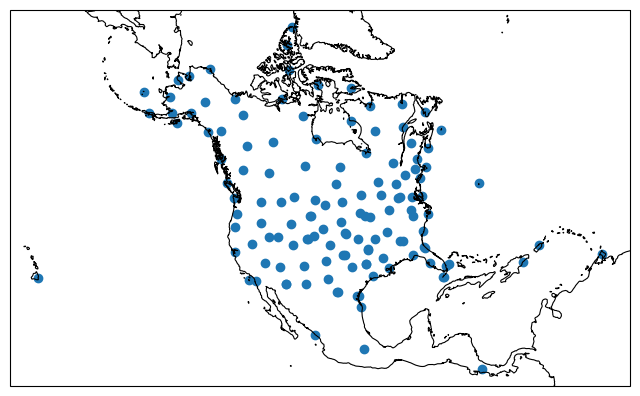

In [46]:
# Plot observation locations on map
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60))
ax.coastlines('50m', linewidth=0.8)

lon, lat = np.meshgrid(df.lon, df.lat)

ax.scatter(df.lon, df.lat, transform=ccrs.PlateCarree())#, df.height)

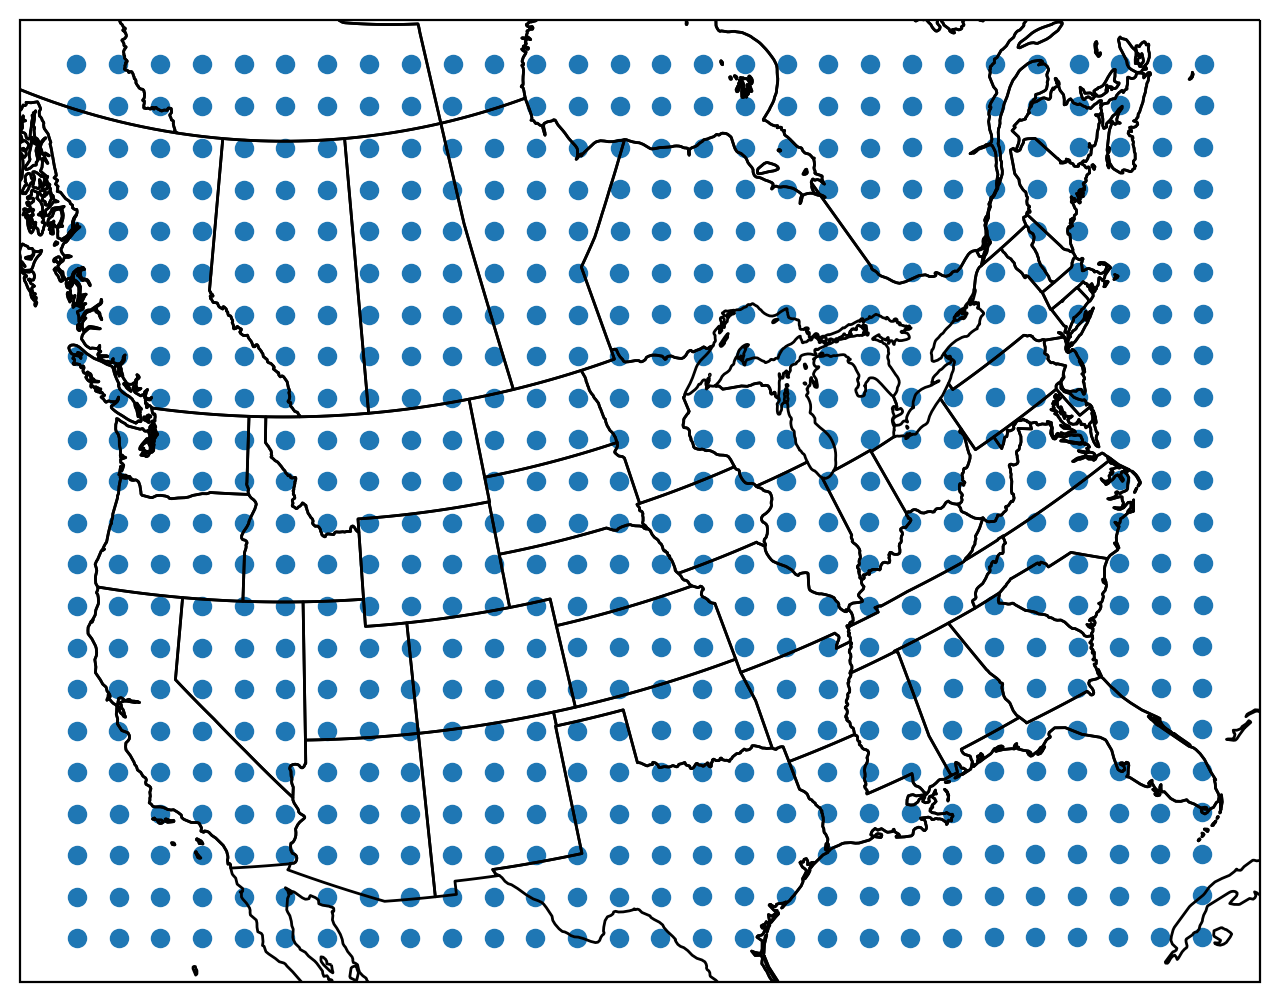

In [47]:
### Set up analysis map with a 22x28 rectangular grid of points ###

### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###

#Known Values
map_scale = 1/15000000
rho = 6371*1e5 #radius of Earth
lambda_o = -115 #standard lon
phi_not = 60 * (np.pi/180) #standard lat

#Create 22x28 grid using correct spacing and start locations
x_s=18.9+np.arange(22)*1.27
y_s=-6.3+np.arange(28)*1.27
x,y = np.meshgrid(x_s,y_s)


#Calculate Image Scale
sigma = (1+np.sin(phi_not))/(1+np.sin(df['lat']*np.pi/180))
#Calculate radius of any latitude circle
r=rho*sigma*np.cos(df['lat']*np.pi/180)*map_scale

#Eq from lat/lon to Grid X/Y
y_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/map_scale)**2+(y/map_scale)**2)/(rho*(1+np.sin(phi_not))))))
#print(y_lat)
x_lon = np.arctan(y/x)*(180/np.pi)+lambda_o
#print(lon_y)
xx=r*np.cos(df.lon*(np.pi/180)-lambda_o*(np.pi/180)) #lambda is longitude
yy=r*np.sin(df.lon*(np.pi/180)-lambda_o*(np.pi/180)) #deviation from standard longitude
#print(xx)


#Plot analysis grid on map
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(x_lon,y_lat, transform=ccrs.PlateCarree())

In [48]:
#Radius of influence 10 and 20cm
roi = np.array([10,20])
#Create empty matrix for obs and analysis
obs_grid_matrix = np.zeros((28,22, len(roi)))
an_grid_matrix = np.zeros((28,22, len(roi)))


#For certain ROI want to find coefficients to satisfy relationship between anaylysis and observations in order to plot height contours on a map at the analysis locations
for i in range(len(roi)):
    roic=roi[i]
    print(roic)
    for j in range(len(x)):
        #print(i)
            for k in range(len(x[j])):
                #print(j)
                xa = x[j,k] - xx #grid point minus obs
                #print(xa)
                ya = y[j,k] - yy #grid point minus obs
                #print(ya)
                
                radius = np.sqrt((xa)**2 + (ya)**2) #distance formula
                #print(radius)
                
                #Create array for/if obs within roi
                idx_array = np.where(radius<=roic)[0]
                #print(idx_array)
                #print(len(idx_array))

                #Observation matrix
                obs_grid_matrix[j,k,i] = len(idx_array)
                #print(obs_grid_matrix[j,k,i])
               
                xk = xa[idx_array] #xk values are only within the ROI for each point
                #print(xk)
                yk = ya[idx_array] #yk values are only within the ROI for each point
                fo = np.array(df.height[idx_array]) #height values only within the ROI for each point
                #print(fo)
                #print(xk)
              
                
                #Create empty 6x6 and 6x1 matrix from general anaylsis equation
                R = np.zeros((6,6))
                O = np.zeros(6)
                
                #Use general analysis equation variables for matrix
                for idx in range(len(yk)):
                    xyk = np.matrix([1, xk.iloc[idx], yk.iloc[idx], xk.iloc[idx]**2, yk.iloc[idx]**2, xk.iloc[idx]*yk.iloc[idx]])
                    #print(xyk) 
                    xykT = np.transpose(xyk)
                                   
                    r = xykT*xyk
                    #print(r)
                    R+=np.array(r)
                    #print(R)
                   
                    o = np.array([fo[idx], fo[idx]*xk.iloc[idx], fo[idx]*yk.iloc[idx], fo[idx]*xk.iloc[idx]**2, fo[idx]*yk.iloc[idx]**2, fo[idx]*xk.iloc[idx]*yk.iloc[idx]])
                    O += o
                
                R = R/obs_grid_matrix[j,k,i]
                #print(R)
                O = O/obs_grid_matrix[j,k,i]
                #print(O)
                c = np.linalg.inv(np.matrix(R))*np.matrix(O).T
                #print(c)
                #print(c[0,0])
                
                #Obtain the matix which has values for the height at the analysis locations
                an_grid_matrix[j,k,i] = c[0,0]
            



10
20


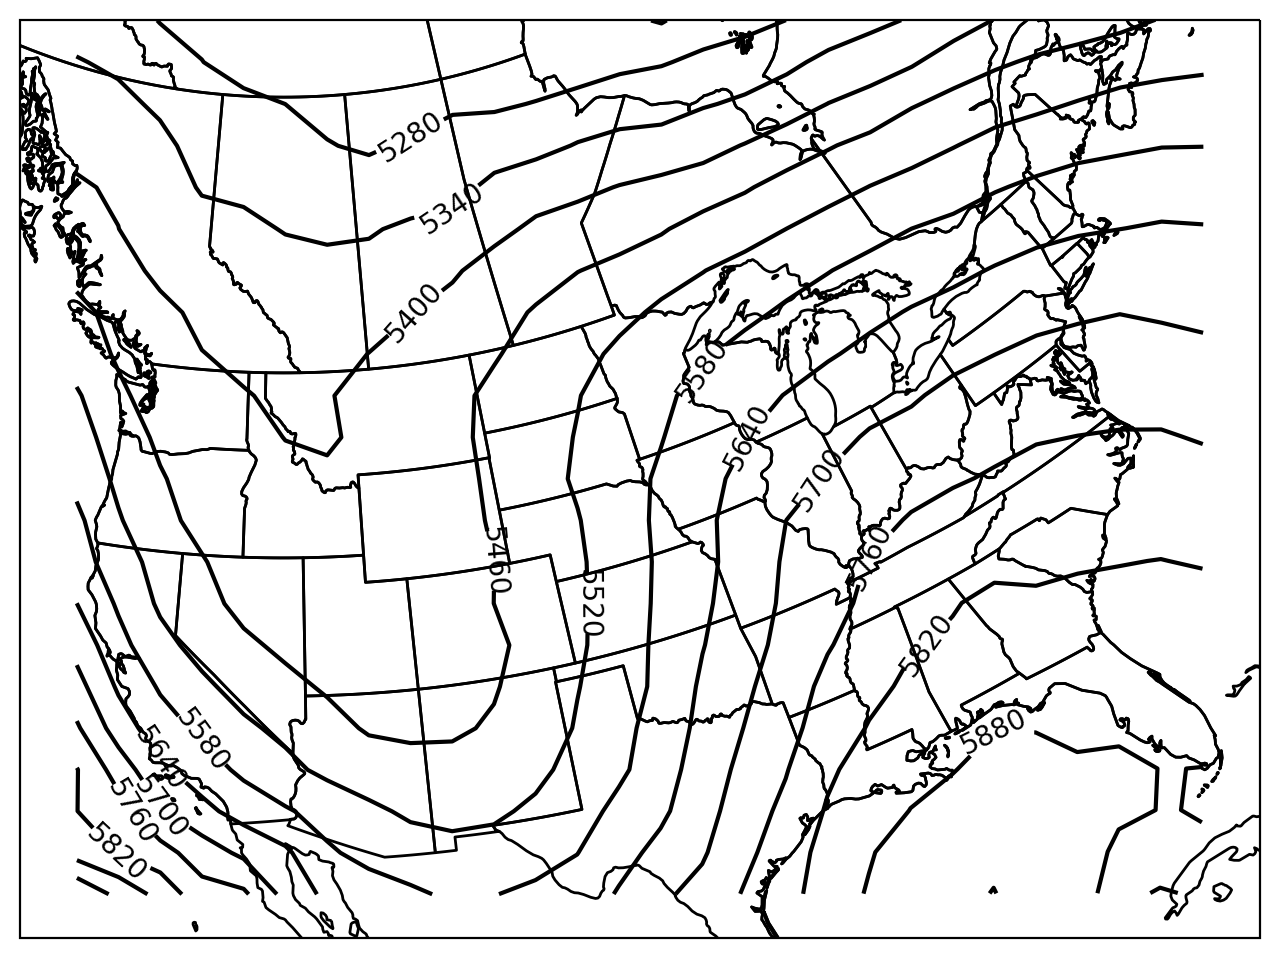

In [63]:
### Plot 500mb analyses over a map for ROI = 10 ### 

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,an_grid_matrix[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('analysis_contour_roi10.png')



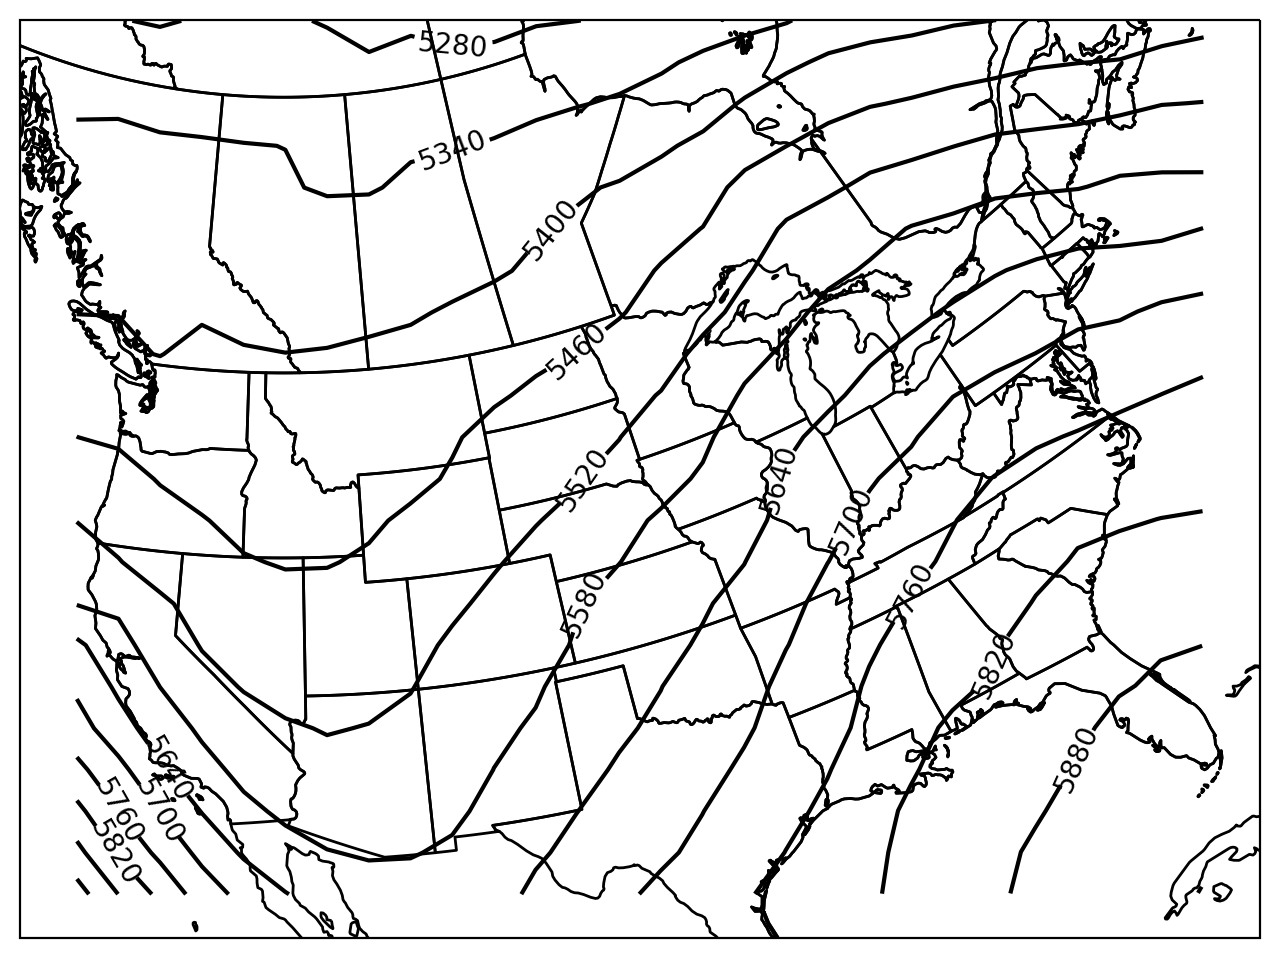

In [64]:
### Plot 500mb analyses over a map for ROI = 20 ###

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,an_grid_matrix[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('analysis_contour_roi20.png')


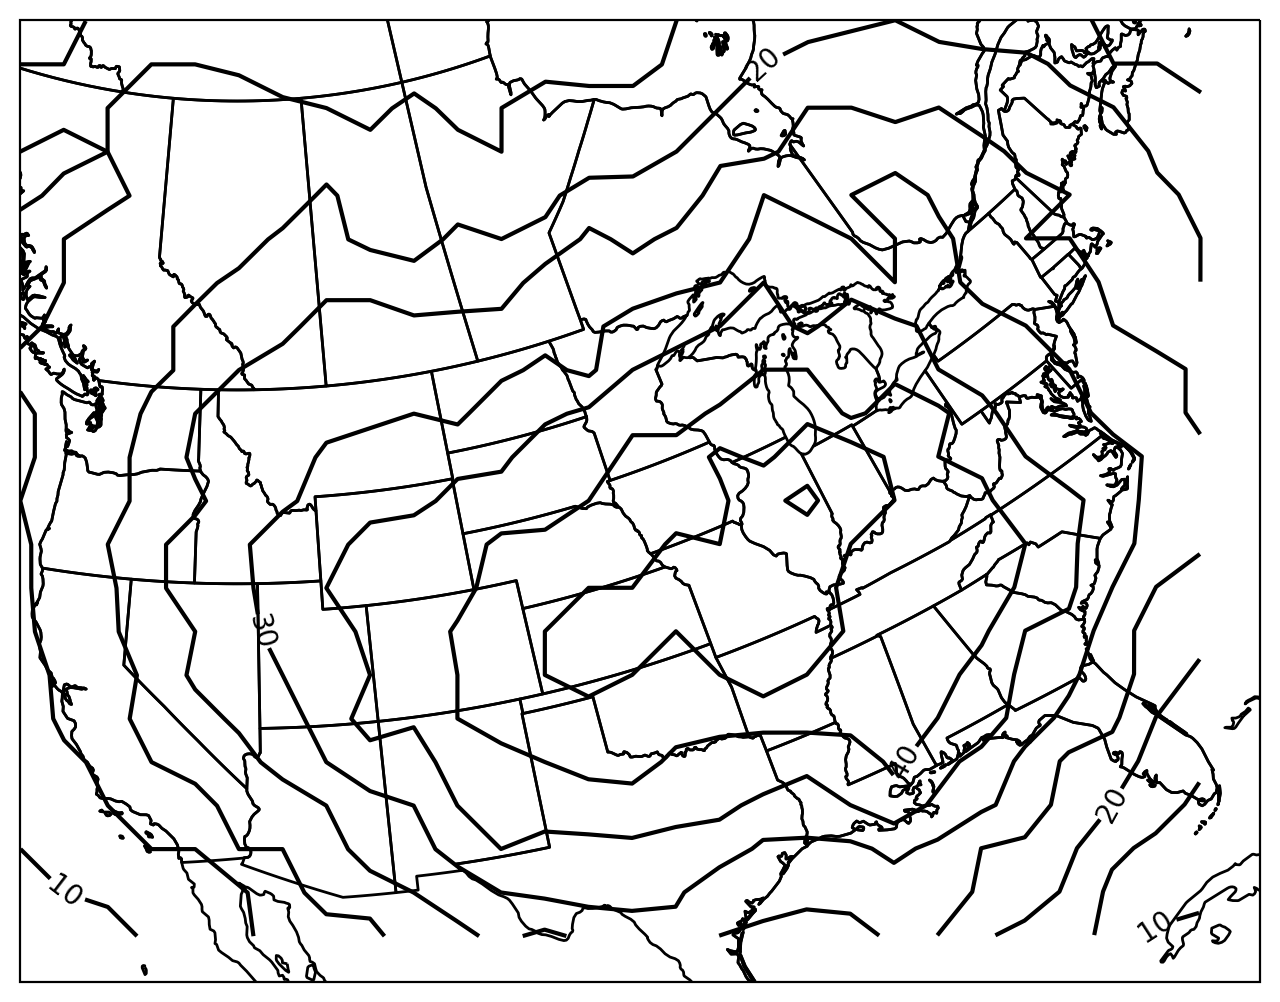

In [65]:
### Plot number of observations available to polynomial fitting scheme for each grid point for ROI = 10 ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,obs_grid_matrix[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.savefig('observation_contour_roi10.png')

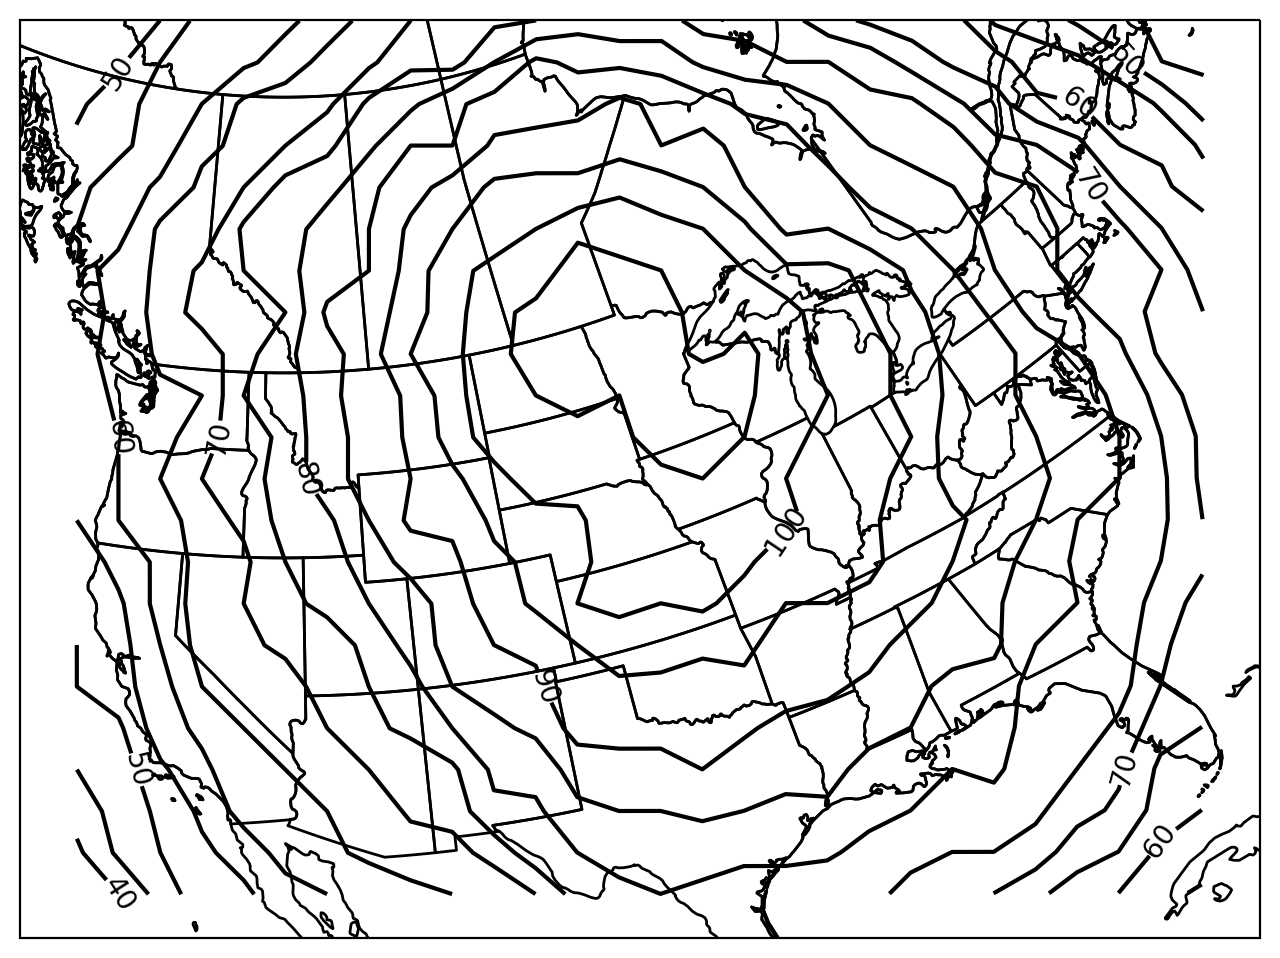

In [66]:
### Plot number of observations available to polynomial fitting scheme for each grid point for ROI = 20 ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,obs_grid_matrix[:,:,1],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.savefig('observation_contour_roi20.png')

In [67]:
### Store the analyses in text files ###
f_an10 = open('analysis_10.txt', 'w')
for row in an_grid_matrix[:,:,0]:
    np.savetxt(f_an10, row)
f_an10.close()


f_an20 = open('analysis_20.txt', 'w')
for row in an_grid_matrix[:,:,1]:
    np.savetxt(f_an20, row)
f_an20.close()

#Test--analysis.txt does not have anything important
#f = open('analysis.txt')
#f.read().splitlines()

In [68]:
### Store the number of observations available for each grid point in text files ###
f_ob10 = open('ob_10.txt', 'w')
for row in obs_grid_matrix[:,:,0]:
    np.savetxt(f_ob10, row)
f_ob10.close()


f_ob20 = open('ob_20.txt', 'w')
for row in obs_grid_matrix[:,:,1]:
    np.savetxt(f_ob20, row)
f_ob20.close()


In [41]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    
    There is troughing (lower heights and thus inferred colder relative temperatures) over the 
    western US while there is ridging (higher heights and inferred warmer relative temperatures) 
    over the eastern US.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
   
   The analysis with a smaller radius of inlfunece (a10) has a deeper trough over the western US. 
   Example of this is that the bottom of the 5460 contour is under Idaho for a20 but reaches farther
   south in AZ and NM for a10. Contours are also spaced closer overall in a10 than in a20. Over the 
   central US contours are orinetated more south-north in a10 than in a20, likely due to increased
   troughing over the western US, even though ridging over the eastern US is relativly the same for both.
   
   The a20 analysis seems to be smoother since there are generally more observations going into each analysis
   point allowing for better coherence. Conversley, a10 has some weird choppy portions since there may be a lack
   of observations in a certain area creating weird features (see near Florida and Montana).
   

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
    Areas in the Gulf of Mexico, Canada, and off the coast of the western US are not reasonable at all. 
    General trough/ridge pattern is captured over most of mainland US, however intensity and location of 
    the trough are off slightly. Issues are due to the fact that there are limited and spread out observations
    in these regions, noted in the map plotting actual observation locations, which is then affecting the function
    fitting routine for height contours at analysis locations. 

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
    No. Since there is only one point the determinate becomes zero which means you can't intvert the matrix.
    Also, maybe another way of thinking about it (I could be wrong), is that since there is only one point,
    you don't (can't?) use a polynomial fit, you just have a singular point.

'''

"\n1 - Describe the general features that you see in your contoured analyses.\n    \n    There is troughing (lower heights and thus inferred colder relative temperatures) over the \n    western US while there is ridging (higher heights and inferred warmer relative temperatures) \n    over the eastern US.\n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n   \n   The analysis with a smaller radius of inlfunece (a10) has a deeper trough over the western US. \n   Example of this is that the bottom of the 5460 contour is under Idaho for a20 but reaches farther\n   south in AZ and NM for a10. Contours are also spaced closer overall in a10 than in a20. Over the \n   central US contours are orinetated more south-north in a10 than in a20, likely due to increased\n   troughing over the western US, even though ridging over the eastern US is relativly the same for both.\n   \n   The 